In [ ]:
# Install required packages
!pip install -q transformers datasets sentencepiece
!pip install -q pytorch-lightning wandb
!pip install -q donut-python

# !huggingface-cli login this shouldh be done from the terminal

In [10]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained("Jac-Zac/thesis_test_donut", revision = '12900abc6fb551a0ea339950462a6a0462820b75')
model = VisionEncoderDecoderModel.from_pretrained("Jac-Zac/thesis_test_donut", revision = '12900abc6fb551a0ea339950462a6a0462820b75')

In [17]:
import re
import json
import torch
from tqdm.auto import tqdm
import numpy as np
import random
from PIL import Image

from donut import JSONParseEvaluator
from datasets import load_dataset

device = "cuda" if torch.cuda.is_available() else "cpu"

model.eval()
model.to(device)

output_list = []
accs = []

image_path = "/Users/jaczac/Github/Thesis/donut_example/small_copy/img_resized"

dataset = load_dataset(image_path, split="test")


for idx, sample in tqdm(enumerate(dataset), total=len(dataset)):
    # prepare encoder inputs
    pixel_values = processor(sample["image"].convert("RGB"), return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    # prepare decoder inputs
    task_prompt = "<s_herbarium>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
    decoder_input_ids = decoder_input_ids.to(device)
    
    # autoregressively generate sequence
    outputs = model.generate(
            pixel_values,
            decoder_input_ids=decoder_input_ids,
            max_length=model.decoder.config.max_position_embeddings,
            early_stopping=True,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            bad_words_ids=[[processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
        )

    # turn into JSON
    seq = processor.batch_decode(outputs.sequences)[0]
    seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
    seq = processor.token2json(seq)

    ground_truth = json.loads(sample["ground_truth"])
    
    # modify ground_truth to replace " " with "" since I would still count it as a correct prediction
    ground_truth = json.loads(sample["ground_truth"].replace('" "', '""'))
    
    evaluator = JSONParseEvaluator()
    score = evaluator.cal_acc(seq, ground_truth)

    accs.append(score)
    output_list.append(seq)

scores = {"accuracies": accs, "mean_accuracy": np.mean(accs)}
print(scores, f"length : {len(accs)}")

Resolving data files:   0%|          | 0/1553 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/138 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/139 [00:00<?, ?it/s]

Found cached dataset imagefolder (/Users/jaczac/.cache/huggingface/datasets/imagefolder/img_resized-7f5590504a871c24/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/138 [00:00<?, ?it/s]

{'accuracies': [0.7567567567567568, 0.7373737373737373, 0.652542372881356, 0.9655172413793104, 0.6285714285714286, 0.8333333333333334, 0.84375, 1.0, 0.6736842105263158, 0.6136363636363636, 1.0, 0.3933333333333333, 0.6911764705882353, 0.19417475728155342, 0.2142857142857143, 0.7, 0.6639999999999999, 0.7777777777777778, 0.5508474576271186, 0.14942528735632188, 0.8333333333333334, 0.28767123287671237, 0.5211267605633803, 0.8701298701298701, 0, 0.7610619469026548, 0.9026548672566371, 0.8333333333333334, 0, 0.7872340425531915, 0.8118811881188119, 1.0, 0.978021978021978, 0.8607594936708861, 0.5421686746987953, 0.6982758620689655, 0.7705882352941177, 0.368421052631579, 0.99, 0.7363636363636363, 0.9125, 0.8454545454545455, 0.8645833333333334, 0.8803418803418803, 0.926829268292683, 0.9894736842105263, 0.9915254237288136, 0.9243697478991597, 0.6714285714285715, 0.19117647058823528, 1.0, 0.8674698795180723, 0.9936305732484076, 1.0, 0.8596491228070176, 0.9855072463768116, 1.0, 0.6153846153846154, 

In [14]:
print("Mean accuracy:", np.mean(accs))

Mean accuracy: 0.8452892073963105


Ground Truth: {"Nome_verbatim": "Athyrium filix-femina (L.) Roth\n", "Nome_floritaly": "Athyrium filix-femina\n(L.) Roth", "Luogo_Raccolta": "Ekeberg", "Altitudine": " ", "Giorno": 2, "Mese": 8.0, "Anno": 1943.0}

Prediction: {'Nome_verbatim': 'Asplenium fluetum fluetum fluetum flue', 'Nome_floritaly': 'Asplenium fluoretum fluorehum L. subsp. fluorehum', 'Luogo_Raccolta': 'Val Fleuris', 'Altitudine': '', 'Giorno': '2', 'Mese': '8.0', 'Anno': '1975.0'}

Score: 0.10588235294117643



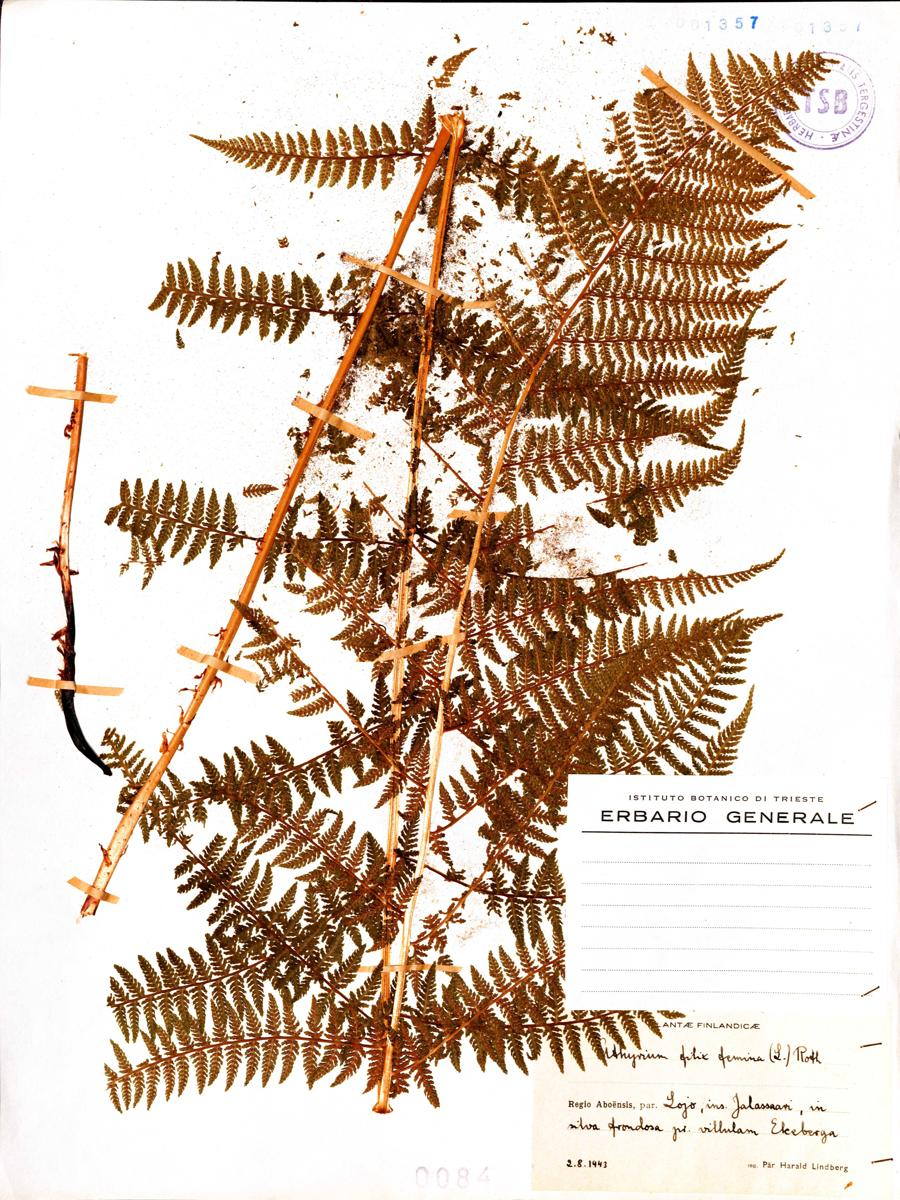

Ground Truth: {"Nome_verbatim": "Azolla filiculoides Lam.", "Nome_floritaly": "Azolla filiculoides Lam", "Luogo_Raccolta": "Kapelle", "Altitudine": 3, "Giorno": 27, "Mese": 5.0, "Anno": 1975.0}

Prediction: {'Nome_verbatim': 'Asplenium fissum Kit.', 'Nome_floritaly': 'Asplenium fissum Kit. ex Willd.', 'Luogo_Raccolta': 'Lago di Flame', 'Altitudine': '300', 'Giorno': '22', 'Mese': '8.0', 'Anno': '1987.0'}

Score: 0.20547945205479456



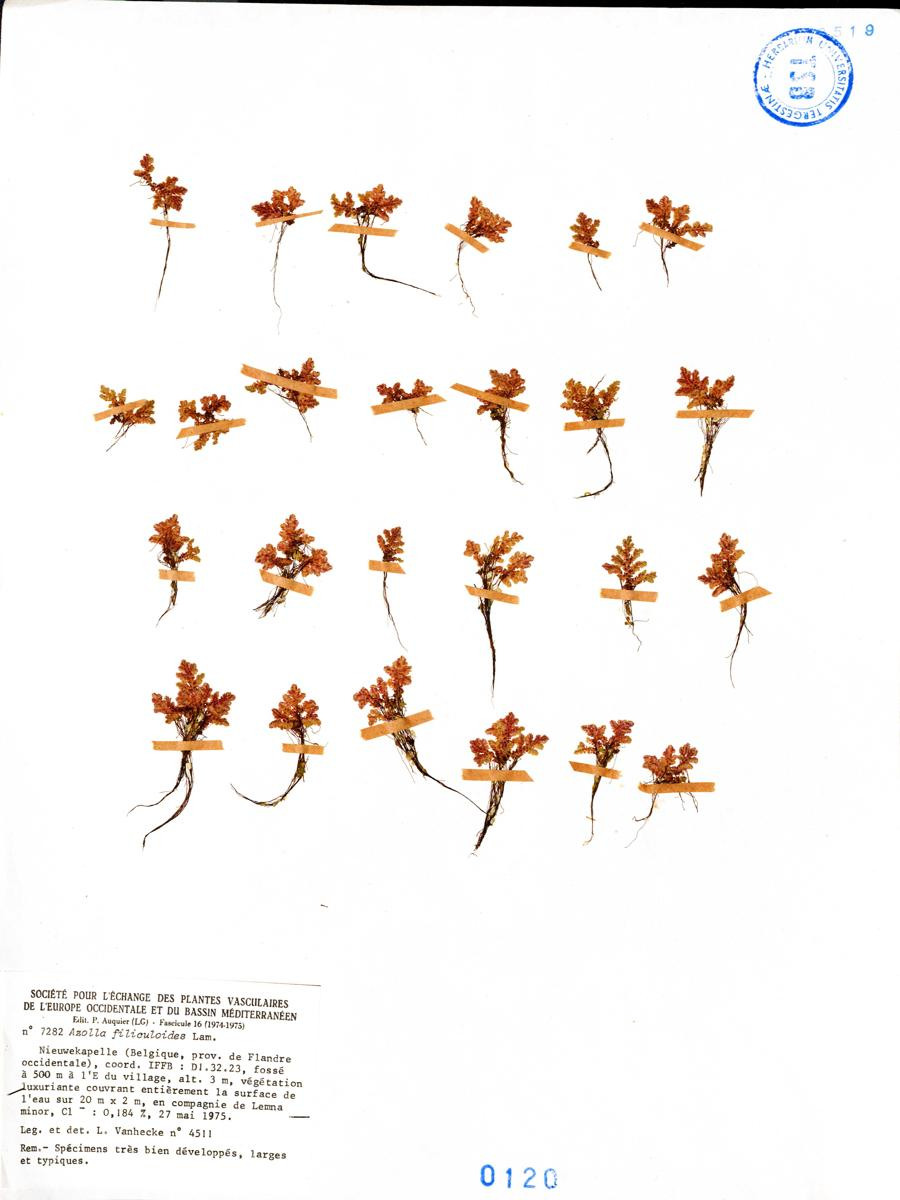

Ground Truth: {"Nome_verbatim": "Pellaea mucronata (D.C. Eat)Tryon) var mucronata", "Nome_floritaly": "Pellaea mucronata D.C.Eaton", "Luogo_Raccolta": "Yosemite Valley", "Altitudine": " ", "Giorno": 18, "Mese": 9.0, "Anno": 1965.0}

Prediction: {'Nome_verbatim': 'Polbia virl', 'Nome_floritaly': 'Polbia virl. virl.', 'Luogo_Raccolta': 'Parco nazionale di Yosemite', 'Altitudine': '', 'Giorno': '18', 'Mese': '9.0', 'Anno': '1965.0'}

Score: 0.20560747663551404



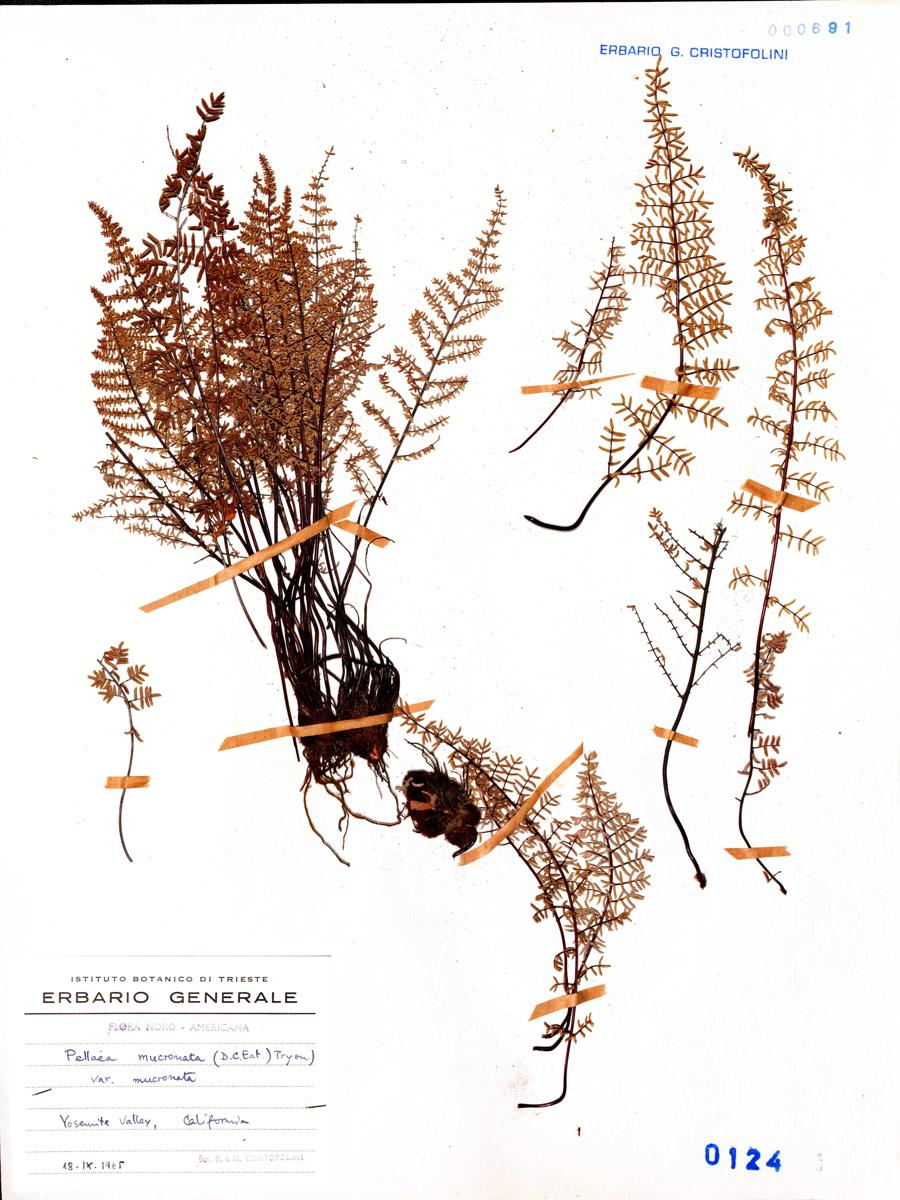

Ground Truth: {"Nome_verbatim": "Equisetum ramosissimum Desf", "Nome_floritaly": "Equisetum ramosissimum Desf.\n", "Luogo_Raccolta": "Parma", "Altitudine": " ", "Giorno": " ", "Mese": 6.0, "Anno": 1962.0}

Prediction: {'Nome_verbatim': 'Equisetum ramosissimum', 'Nome_floritaly': '', 'Luogo_Raccolta': '', 'Altitudine': '', 'Giorno': '', 'Mese': '', 'Anno': ''}

Score: 0.31081081081081086



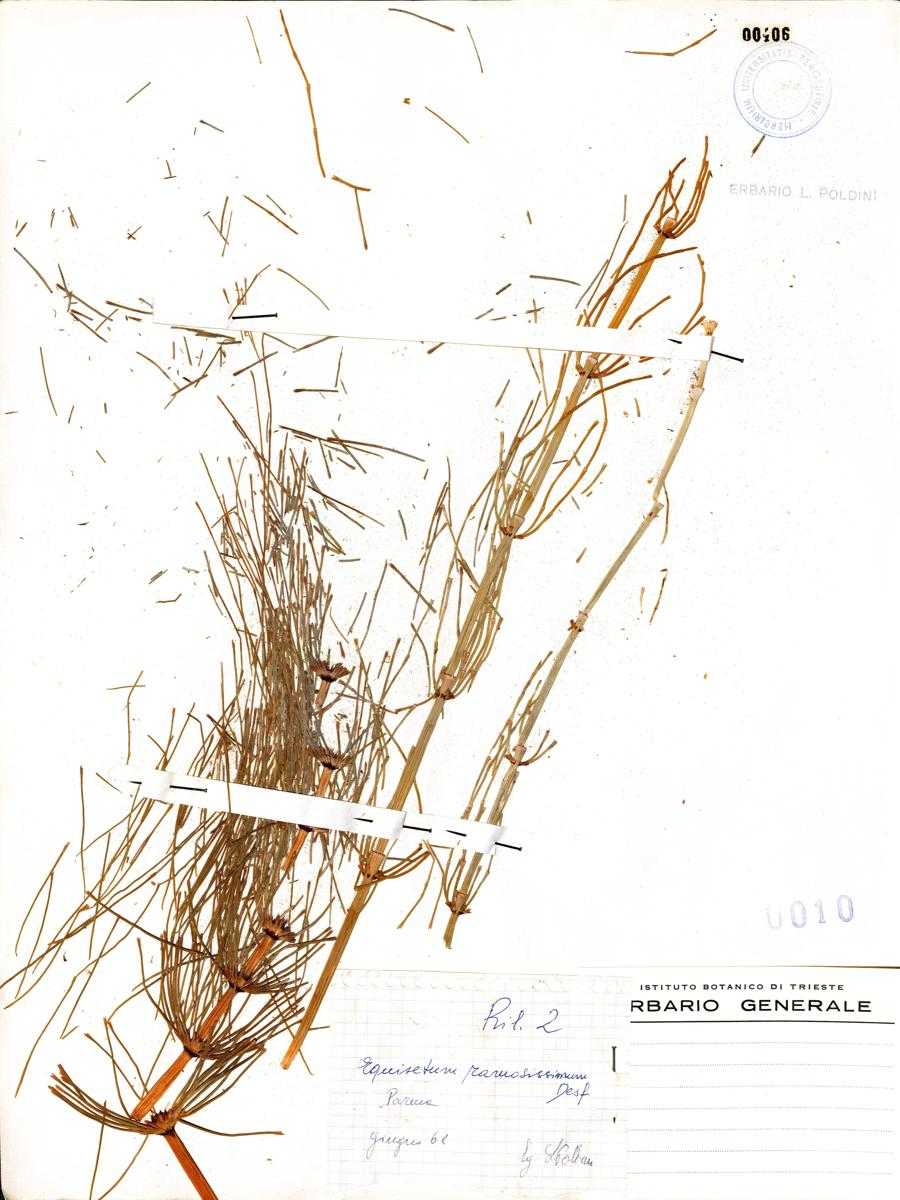

Ground Truth: {"Nome_verbatim": "Dryopteris aemula (Ait.) O. Kuntze", "Nome_floritaly": "Dryopteris aemula\n(Aiton) Kuntze", "Luogo_Raccolta": "Vall\u00e9e du Laxia", "Altitudine": " ", "Giorno": 3, "Mese": 7.0, "Anno": 1977.0}

Prediction: {'Nome_verbatim': 'Asplenium trichomanes L.', 'Nome_floritaly': 'Asplenium trichomanes L.', 'Luogo_Raccolta': 'Valle del Norda', 'Altitudine': '', 'Giorno': '3', 'Mese': '7.0', 'Anno': '1972.0'}

Score: 0.35051546391752575



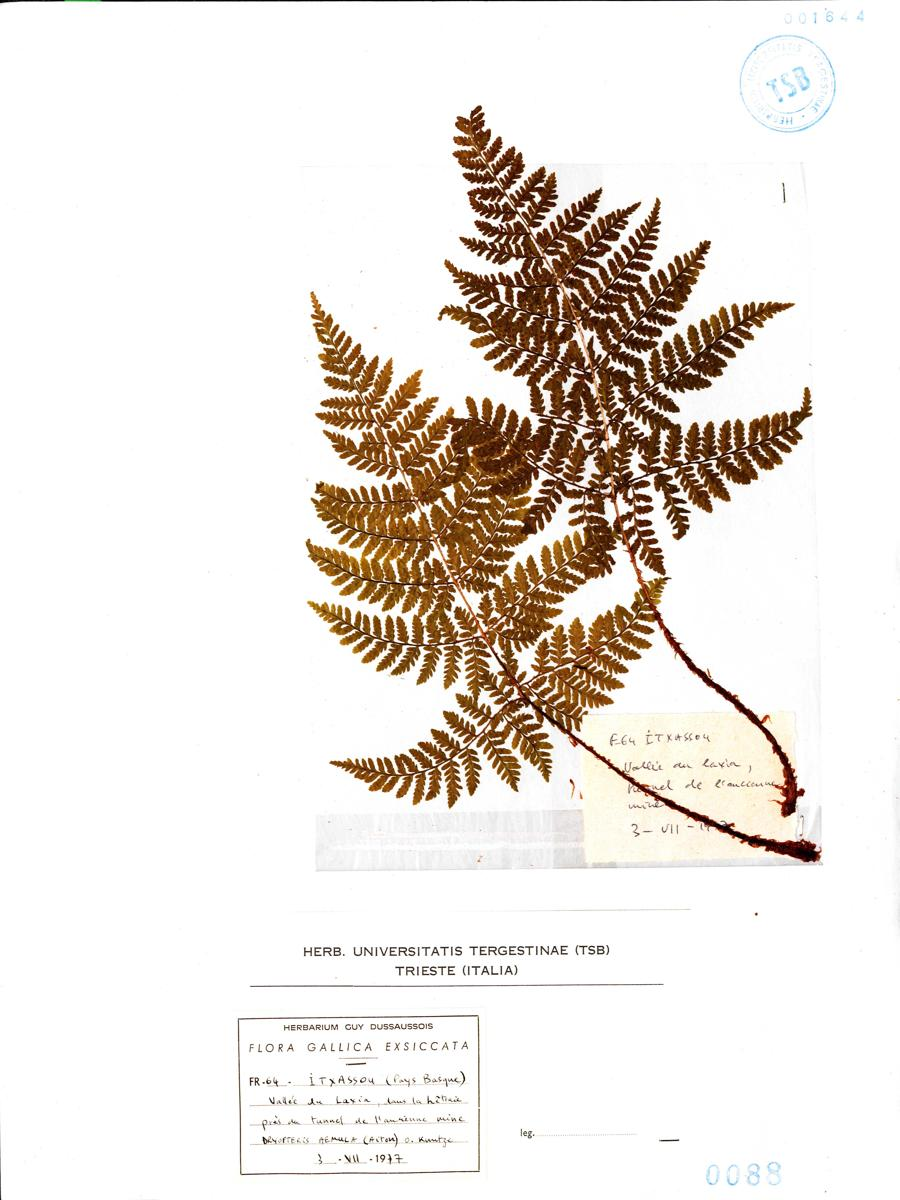

In [16]:
# get indices of worst 5 predictions
worst_idxs = np.argsort(accs)[:5].tolist()

# prepare decoder inputs
task_prompt = "<s_herbarium>"
decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
decoder_input_ids = decoder_input_ids.to(device)

for idx in worst_idxs:
    sample = dataset[idx]

    # prepare encoder inputs
    pixel_values = processor(sample["image"].convert("RGB"), return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)

    # autoregressively generate sequence
    outputs = model.generate(
        pixel_values,
        decoder_input_ids=decoder_input_ids,
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )

    # turn into JSON
    seq = processor.batch_decode(outputs.sequences)[0]
    seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
    seq = processor.token2json(seq)
    
    print(f"Ground Truth: {sample['ground_truth']}\n")
    print(f"Prediction: {seq}\n")
    print(f"Score: {accs[idx]}\n")
    display(sample["image"])